# Comprehensive Analysis of Ego4D NLQ Annotations

## 1. Setup Environment

### Import Required Libraries
Import libraries for data manipulation, visualization, and numerical operations

In [1]:
# Standard libraries
import os
import json
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook settings
plt.style.use('ggplot')
sns.set(style="whitegrid", palette="deep")

### Download required Data folder

In [ ]:
!gdown --folder "https://drive.google.com/drive/folders/1zbdBSLp-QfJYHUQI_j7aI3nd7NkLP2Uj?usp=drive_link"

### Define File Paths
Set paths to annotation files and metadata.

In [2]:
# Define paths to data directory and files
data_dir = "data/ego4d_data"
annotations_file = os.path.join(data_dir, "v1", "annotations/nlq_train.json")
metadata_file = os.path.join(data_dir, "ego4d.json")

# Confirm file existence
assert os.path.exists(annotations_file), "NLQ annotations file not found."
assert os.path.exists(metadata_file), "Metadata file not found."

print("All files are accessible. Ready to load data.")

All files are accessible. Ready to load data.


## 2. Load and Inspect the Data

### Load NLQ Annotations
Load the annotations and inspect the structure.

In [3]:
# Load NLQ annotations
with open(annotations_file, 'r') as f:
    nlq_data = json.load(f)

print("Top-level keys in NLQ annotations:", nlq_data.keys())
print("Number of videos:", len(nlq_data['videos']))

Top-level keys in NLQ annotations: dict_keys(['version', 'date', 'description', 'manifest', 'videos'])
Number of videos: 754


### Load Metadata
Load the metadata file and inspect its structure.

In [4]:
# Load metadata
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print("Top-level keys in Metadata:", metadata.keys())
print("Number of videos in Metadata:", len(metadata['videos']))

Top-level keys in Metadata: dict_keys(['date', 'version', 'description', 'videos', 'clips', 'concurrent_video_sets', 'physical_settings', 'moments_labels'])
Number of videos in Metadata: 9645


In [5]:
print("queries:")
print(nlq_data['videos'][0]["clips"][0]['annotations'][1]['language_queries'][3]["query"])

queries:
Where did I put a meat container.


### Transform Data into a DataFrame
Extract relevant fields from the NLQ annotations into a structured DataFrame.

In [6]:
# Initialize list to store extracted data
nlq_list = []

for video in nlq_data['videos']:
    video_uid = video['video_uid']
    for clip in video['clips']:
        clip_uid = clip['clip_uid']
        for annotation in clip['annotations']:
            for nlq in annotation['language_queries']:
                if 'query' in nlq and nlq["query"] != "":
                    nlq_list.append({
                        'video_uid': video_uid,
                        'clip_uid': clip_uid if clip_uid else "N/A",  # Replace missing with N/A
                        'query': nlq['query'],  # Query is assumed to exist at this point
                        'template': nlq['template'] if 'template' in nlq else "N/A",
                        'slot_x': nlq['slot_x'] if 'slot_x' in nlq else "N/A",
                        'verb_x': nlq['verb_x'] if 'verb_x' in nlq else "N/A",
                        'slot_y': nlq['slot_y'] if 'slot_y' in nlq else "N/A",
                        'verb_y': nlq['verb_y'] if 'verb_y' in nlq else "N/A",
                        'clip_start_sec': nlq['clip_start_sec'] if 'clip_start_sec' in nlq else 0.0,
                        'clip_end_sec': nlq['clip_end_sec'] if 'clip_end_sec' in nlq else 0.0,
                        'video_start_sec': nlq['video_start_sec'] if 'video_start_sec' in nlq else 0.0,
                        'video_end_sec': nlq['video_end_sec'] if 'video_end_sec' in nlq else 0.0,
                        'video_start_frame': nlq['video_start_frame'] if 'video_start_frame' in nlq else 0,
                        'video_end_frame': nlq['video_end_frame'] if 'video_end_frame' in nlq else 0,
                        'duration': (nlq['clip_end_sec'] - nlq['clip_start_sec']) 
                                    if 'clip_end_sec' in nlq and 'clip_start_sec' in nlq else 0.0
                    })

# Convert to DataFrame
nlq_df = pd.DataFrame(nlq_list)

# Display overview
print("NLQ Annotations DataFrame:")
print(nlq_df.head())
nlq_df.info()

NLQ Annotations DataFrame:
                              video_uid                              clip_uid  \
0  d250521e-5197-44aa-8baa-2f42b24444d2  fae92e70-88aa-4b77-b41a-5879b74c804c   
1  d250521e-5197-44aa-8baa-2f42b24444d2  fae92e70-88aa-4b77-b41a-5879b74c804c   
2  d250521e-5197-44aa-8baa-2f42b24444d2  fae92e70-88aa-4b77-b41a-5879b74c804c   
3  d250521e-5197-44aa-8baa-2f42b24444d2  fae92e70-88aa-4b77-b41a-5879b74c804c   
4  d250521e-5197-44aa-8baa-2f42b24444d2  fae92e70-88aa-4b77-b41a-5879b74c804c   

                                               query  \
0       How many frying pans can i see on the shelf?   
1  What colour bowl did i carry from the plate st...   
2             In what location did i see the basket?   
3                       What did i pour in the bowl?   
4          Where was the soap before i picked it up?   

                                            template              slot_x  \
0         Objects: How many X’s? (quantity question)         frying pans 

## 3. Exploratory Data Analysis (EDA)

### 3.1 Distribution of Segment Durations
Visualize the distribution of segment durations in the dataset. The histogram uses 100 bins to provide a detailed view, and a kernel density estimate (KDE) overlays the data for smooth visualization. The x-axis represents segment duration in seconds, while the y-axis shows the frequency of segments. You can uncomment the `plt.ylim` line to inspect values for higher-duration segments (up to 500 seconds) if needed. This visualization helps identify common duration ranges and outliers in the dataset. 

(The KDE is a statistical tool used to estimate the probability density function (PDF) of the data. It provides a smoothed continuous curve that helps visualize the underlying distribution of the data more intuitively, compared to the discrete bars of the histogram.)

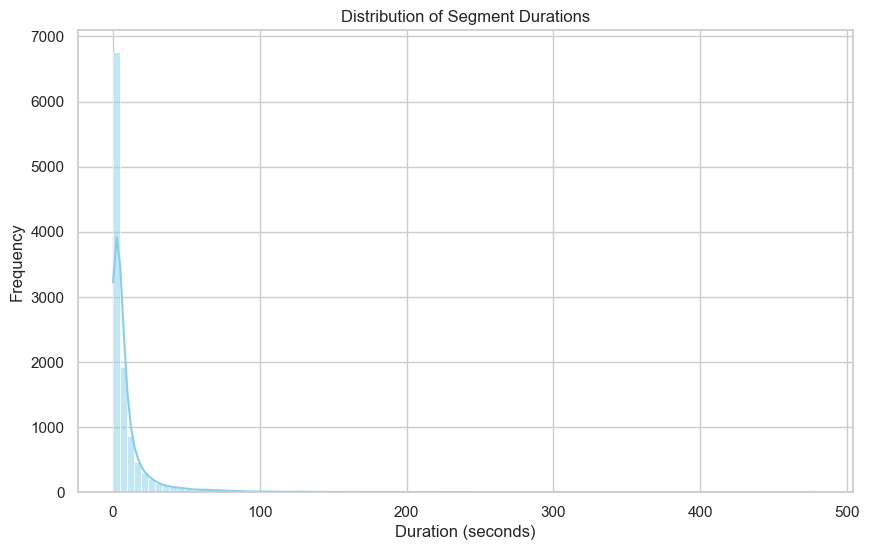

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(nlq_df['duration'], bins=100, kde=True, color="skyblue")
plt.title("Distribution of Segment Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
# plt.ylim(0, 100) remove comment to see values for high duration clips (500)
plt.show()

### 3.2 Distribution of Templates
This code analyzes the distribution of query templates in the dataset. It counts the occurrences of each template using `value_counts()` and creates a DataFrame to structure the data. A bar plot is then generated using `sns.barplot`, showing the number of queries per template with a distinct color for each. The plot provides an intuitive visualization of which templates are most and least common, offering insights into query distribution. The hue parameter ensures each bar is uniquely colored, while dodge=False avoids overlapping bars. This visualization helps identify patterns or imbalances in template usage.

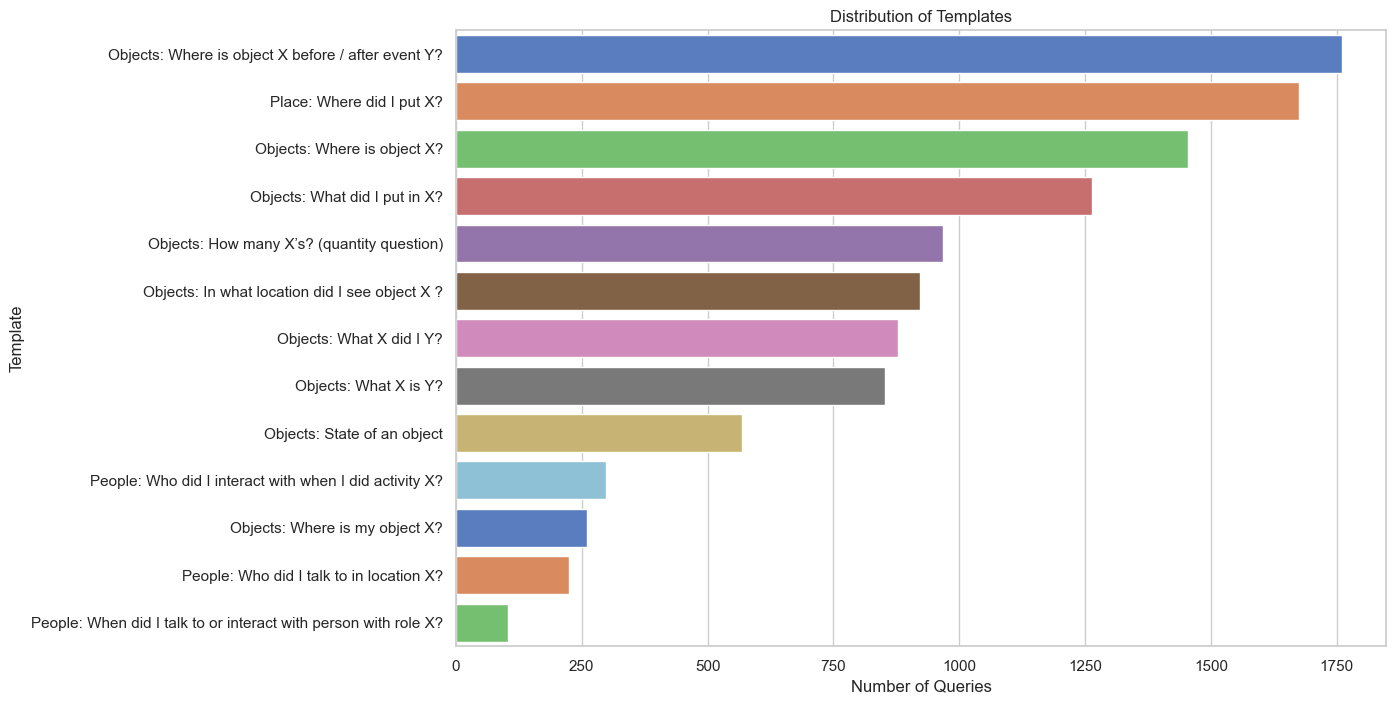

In [10]:
# Count template occurrences
template_counts = nlq_df['template'].value_counts()

template_df = template_counts.reset_index()
template_df.columns = ['template', 'count']

# Bar plot with hue
plt.figure(figsize=(12, 8))
sns.barplot(y='template', x='count', hue='template', data=template_df, dodge=False, palette="muted", legend=False)
plt.title("Distribution of Templates")
plt.xlabel("Number of Queries")
plt.ylabel("Template")
plt.show()

### 3.3 Query Analysis: Most Common Phrases
This code identifies and visualizes the top 20 most frequent queries in the dataset. Using `value_counts()`, it counts the occurrences of each query and extracts the top 20. The results are displayed in a horizontal bar plot using `sns.barplot`, with queries on the Y-axis and their frequencies on the X-axis. This analysis highlights the most common queries, providing insights into query repetition and potential biases in the dataset.

/var/folders/45/8pg0bn7j607c25j6kncj430w0000gn/T/ipykernel_17127/480046538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=query_counts.index, x=query_counts.values, palette="viridis")


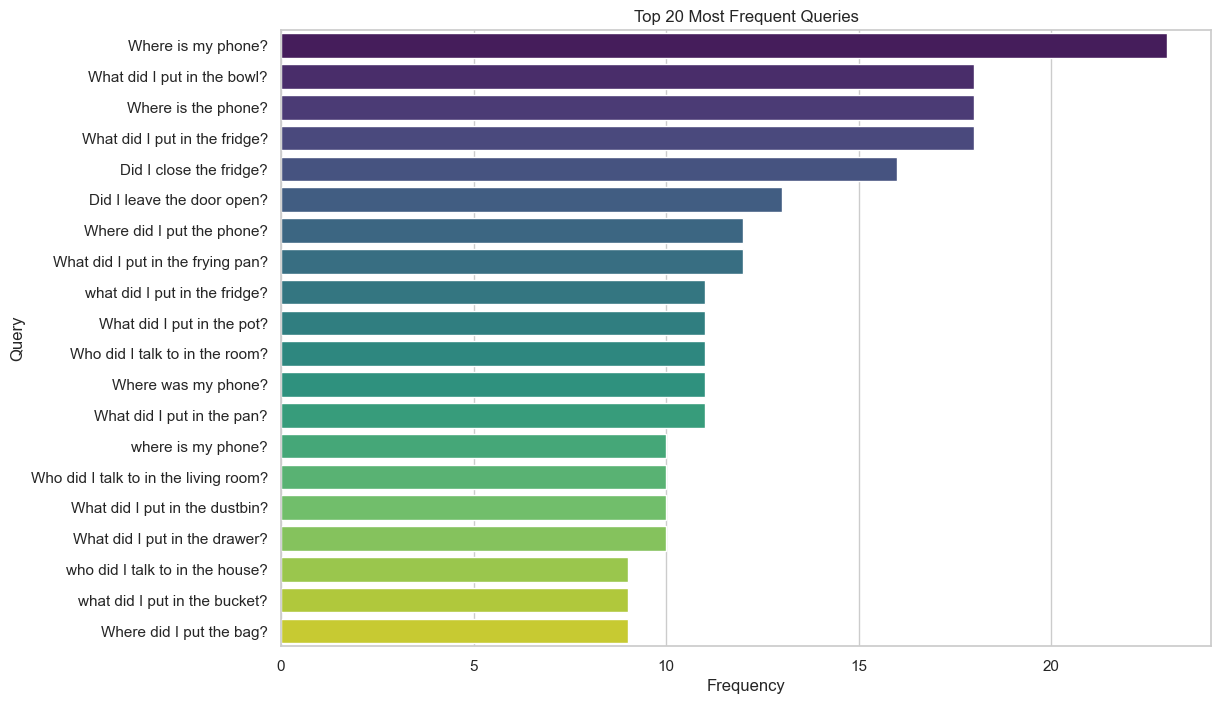

In [9]:
# Count the most frequent queries
query_counts = nlq_df['query'].value_counts().head(20)

# Convert query_counts to a DataFrame for compatibility with hue
query_counts_df = query_counts.reset_index()
query_counts_df.columns = ['query', 'frequency']

# Plot the top 20 most frequent queries with hue assigned
plt.figure(figsize=(12, 8))
sns.barplot(y='query', x='frequency', hue='query', dodge=False, data=query_counts_df, palette="viridis", legend=False)
plt.title("Top 20 Most Frequent Queries")
plt.xlabel("Frequency")
plt.ylabel("Query")
plt.show()

### 3.4 Temporal Distribution of Annotations
This section computes the relative position of each annotation within its video, defined as the start time of the segment normalized by the video duration. The scatter plot visualizes how segment durations vary across different positions in the video. By plotting `relative_position` against duration, we can identify trends, such as whether longer annotations cluster at specific points (e.g., beginning or end of videos). The use of transparency (alpha=0.5) improves readability by reducing overlap in dense regions. This visualization aids in understanding temporal patterns within the dataset.

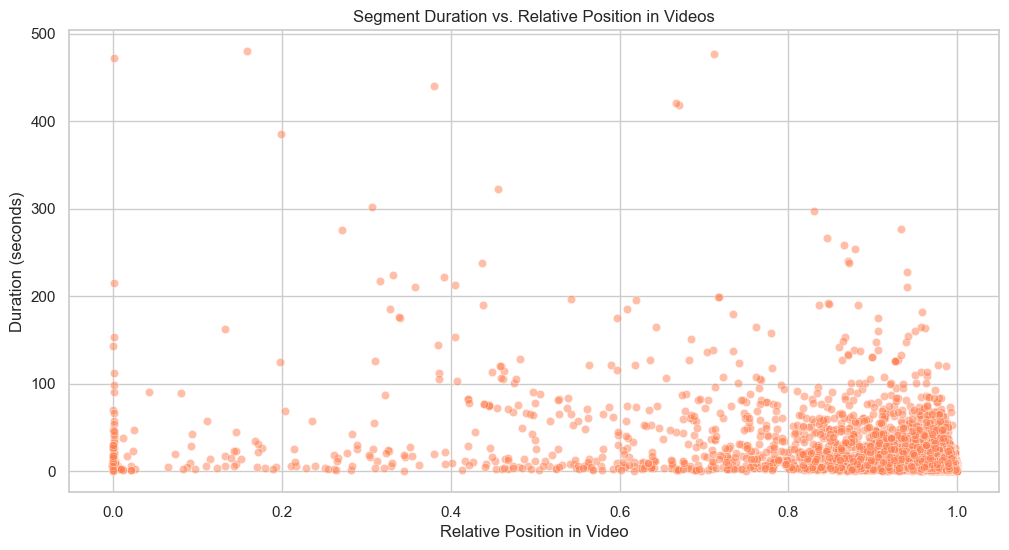

In [10]:
# Calculate relative position in the video
nlq_df['relative_position'] = nlq_df['video_start_sec'] / (nlq_df['video_end_sec'] + 1e-6)

# Scatter plot of duration vs. relative position
plt.figure(figsize=(12, 6))
sns.scatterplot(x=nlq_df['relative_position'], y=nlq_df['duration'], alpha=0.5, color="coral")
plt.title("Segment Duration vs. Relative Position in Videos")
plt.xlabel("Relative Position in Video")
plt.ylabel("Duration (seconds)")
plt.show()

### 3.5 Slot and Verb Analysis
This section focuses on understanding the most common objects (slot_x) and actions (verb_x) in the dataset. Using `value_counts()`, we identify the top 20 most frequent entries for each field and visualize their distributions through bar plots. These visualizations provide insights into the dataset’s content, highlighting recurring patterns in objects and verbs. The use of distinct color palettes ensures clarity, while the focus on the top occurrences simplifies interpretation and reveals dominant trends efficiently.

/var/folders/45/8pg0bn7j607c25j6kncj430w0000gn/T/ipykernel_19511/4224511517.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=slot_x_counts.index, x=slot_x_counts.values, palette="pastel")


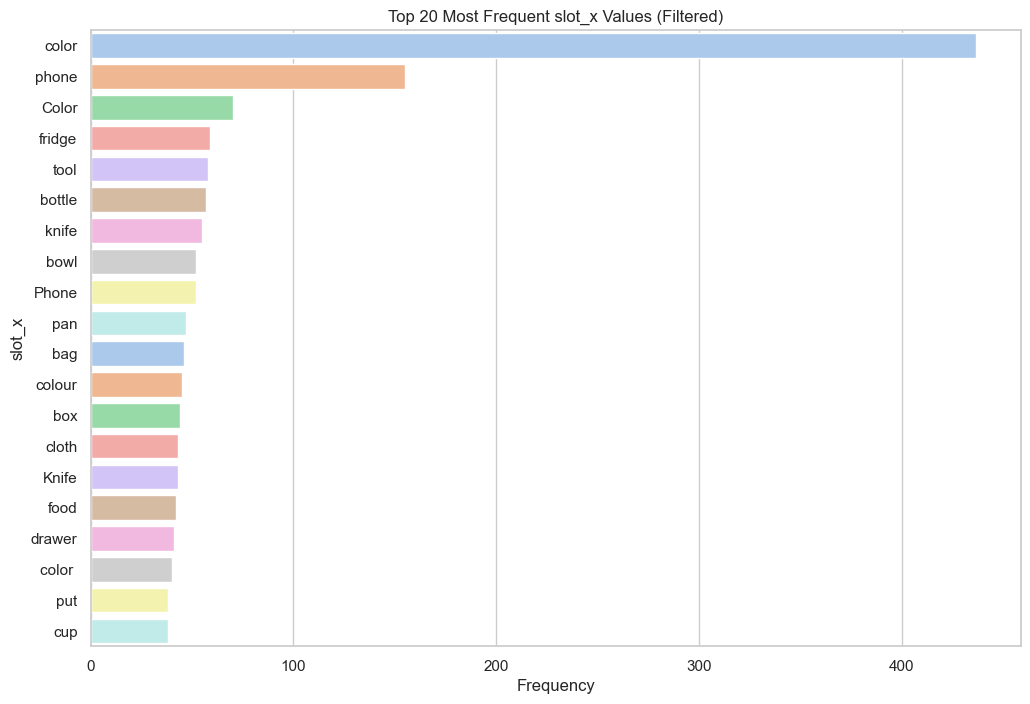

/var/folders/45/8pg0bn7j607c25j6kncj430w0000gn/T/ipykernel_19511/4224511517.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=verb_x_counts.index, x=verb_x_counts.values, palette="autumn")


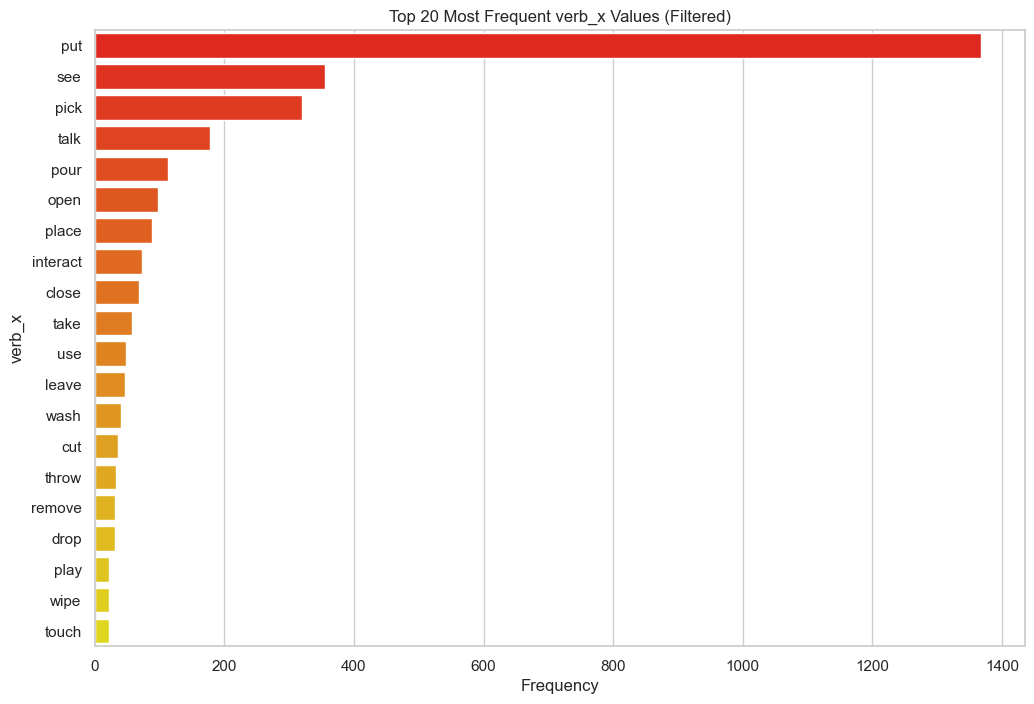

In [11]:
# Filter out unwanted values for slot_x and verb_x
filtered_slot_x = nlq_df[~nlq_df['slot_x'].isin(["N/A"])]
filtered_verb_x = nlq_df[~nlq_df['verb_x'].isin(["N/A", "[verb_not_applicable]", "[verb_not_in_list]"])]

# Count top 20 occurrences for slot_x and verb_x after filtering
slot_x_counts = filtered_slot_x['slot_x'].value_counts().head(20)
verb_x_counts = filtered_verb_x['verb_x'].value_counts().head(20)

# Plot slot_x frequencies
plt.figure(figsize=(12, 8))
sns.barplot(y=slot_x_counts.index, x=slot_x_counts.values, palette="pastel")
plt.title("Top 20 Most Frequent slot_x Values (Filtered)")
plt.xlabel("Frequency")
plt.ylabel("slot_x")
plt.show()

# Plot verb_x frequencies
plt.figure(figsize=(12, 8))
sns.barplot(y=verb_x_counts.index, x=verb_x_counts.values, palette="autumn")
plt.title("Top 20 Most Frequent verb_x Values (Filtered)")
plt.xlabel("Frequency")
plt.ylabel("verb_x")
plt.show()

## 4. Advanced Analysis

### 4.1 Template-Query Correlation
This section analyzes the diversity of queries within each template by counting the number of unique queries associated with each template. The data is grouped by template, and a horizontal bar chart is used to visualize the results. Templates with a higher number of unique queries indicate broader usage or variability, while templates with fewer unique queries might suggest narrower or repetitive usage. This visualization provides insights into the complexity and variety of queries within the dataset.

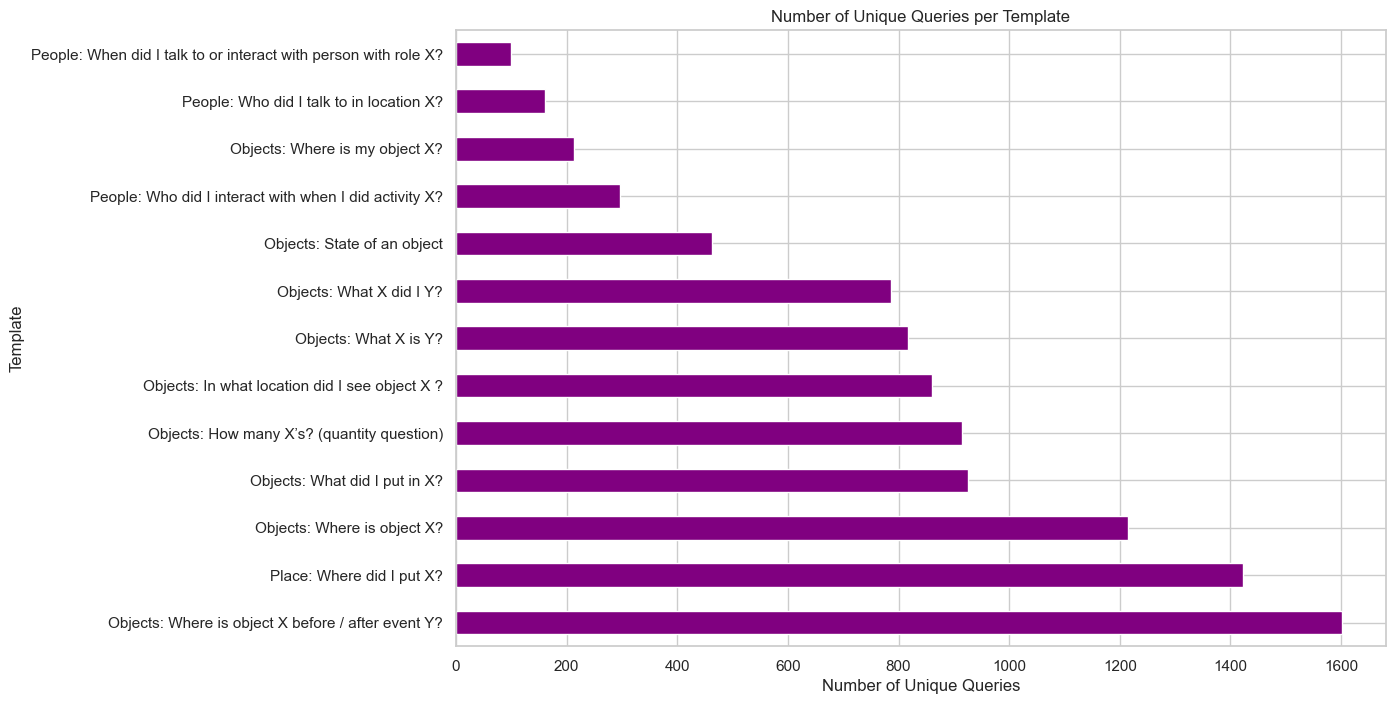

In [12]:
# Group queries by template
template_query_counts = nlq_df.groupby('template')['query'].nunique()

# Bar plot
plt.figure(figsize=(12, 8))
template_query_counts.sort_values(ascending=False).plot(kind='barh', color="purple")
plt.title("Number of Unique Queries per Template")
plt.xlabel("Number of Unique Queries")
plt.ylabel("Template")
plt.show()

### 4.2 Temporal Clustering
This kernel density estimation (KDE) plot visualizes the distribution of query positions relative to the full video duration. The `relative_position` metric provides insight into where annotations are concentrated within the timeline of videos. By filling the area under the curve and adjusting transparency, the plot effectively highlights density peaks, helping identify trends such as whether annotations are more frequent at the start, middle, or end of videos. This visualization is particularly useful for detecting temporal biases in the dataset.

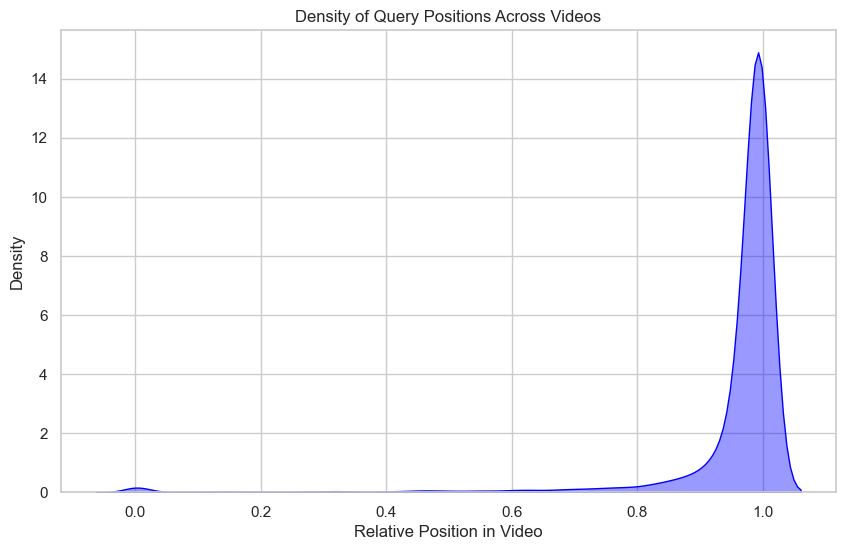

In [13]:
# KDE plot of relative positions
plt.figure(figsize=(10, 6))
sns.kdeplot(nlq_df['relative_position'], fill=True, color="blue", alpha=0.4)
plt.title("Density of Query Positions Across Videos")
plt.xlabel("Relative Position in Video")
plt.ylabel("Density")
plt.show()